<a href="https://colab.research.google.com/github/Ghioc-Mihai-Bogdan/Coffee-machine/blob/main/Tacai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1) Import data - DONE
# 2) Shuffle the data - DONE
# 3) Train test split - DONE
# 4) Preprocess the data:
#     a) normalizare
#     b) resize - DONE-ish
#     c) augumentare - NICE 2 HAVE
#     d) remove/accout4 autliers - Not 4 us
#     e) dataset balancing - Not 4 us
#     f) hand segmentation - Done
#     g) hand extraction - Done
# 5) Feature extraction
# 6) Classifier
# PR, Confusion Matrix, etc

# **ish means do a for loop for all the images

In [2]:
import numpy as np

import random

def sp_noise(image, prob):

    """

    Add salt and pepper noise to an image.

    Parameters:

        image (numpy.ndarray): Input image array.

        prob (float): Probability of noise (between 0 and 1).

    Returns:

        numpy.ndarray: Image with salt and pepper noise added.

    """

    if not (0 <= prob <= 1):

        raise ValueError("Probability 'prob' must be between 0 and 1.")

    if not isinstance(image, np.ndarray):

        raise TypeError("Input 'image' must be a numpy array.")

    # Create a copy of the image to preserve the original

    output = np.copy(image)

    total_pixels = image.size

    # Calculate the number of salt and pepper pixels

    num_salt = int(total_pixels * prob)

    num_pepper = int(total_pixels * prob)

    # Randomly pick indices for salt and pepper

    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]

    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]

    # Add salt (white pixels)

    output[tuple(salt_coords)] = 255

    # Add pepper (black pixels)

    output[tuple(pepper_coords)] = 0

    return output



0. Import Libs



In [3]:
import cv2
import numpy as np
import glob
import random
import matplotlib.pyplot as plt

1. Import data (PART 1)

In [4]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
bp = "/content/drive/MyDrive/fac/Laborator/Images/"
file_path_arr = []
for i in range(4):
  file_path_arr.append(glob.glob(bp+str(i)+'/*.jpg'))
print(file_path_arr)
print(len(file_path_arr))

[['/content/drive/MyDrive/fac/Laborator/Images/0/9.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/3.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/4.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/2.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/8.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/7.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/5.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/0.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/1.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/6.jpg'], ['/content/drive/MyDrive/fac/Laborator/Images/1/6.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/7.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/0.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/1.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/9.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/3.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/5.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/2.jpg', '/cont

2) Shuffle the data

In [6]:
random.seed(42)

In [7]:
image_index_arr = random.sample(range(0, 9), 7)
print(image_index_arr)

[1, 0, 5, 2, 8, 4, 7]


In [9]:
train_img_path = []
test_img_path = []

for habd_class in file_path_arr:
  tmp_train = []
  tmp_test = []
  for i in range(len(habd_class)):
    if i not in image_index_arr:
      tmp_test.append(habd_class[i])
    else:
      tmp_train.append(habd_class[i])
  train_img_path.append(tmp_train)
  test_img_path.append(tmp_test)

print(np.shape(train_img_path))
print(np.shape(test_img_path))

(4, 7)
(4, 3)


1. Import data (Part 2)

In [10]:
train_images = []
test_images = []

for cls in train_img_path:
  t = []
  for i in cls:
    t.append(cv2.imread(i))
  train_images.append(t)

for cls in test_img_path:
  t = []
  for i in cls:
    t.append(cv2.imread(i))
  test_images.append(t)

print(np.shape(train_images))
print(np.shape(test_images))

(4, 7, 4032, 1908, 3)
(4, 3, 4032, 1908, 3)


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7c42dc001ad0>)

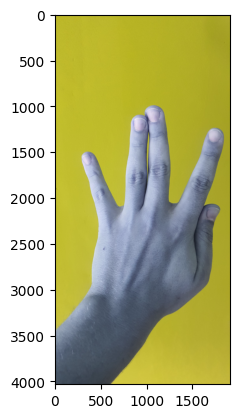

In [17]:
plt.figure(), plt.imshow(train_images[0][0])

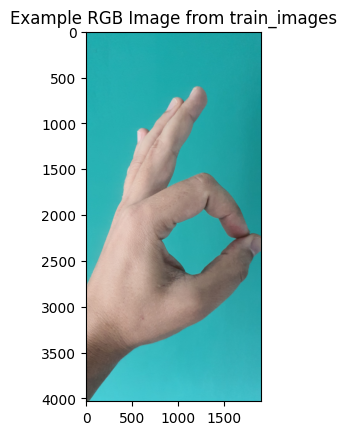

In [35]:
# Convert all images in train_images from BGR to RGB
train_images_rgb = []
for class_images in train_images:
    rgb_class_images = []
    for image in class_images:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        rgb_class_images.append(rgb_image)
    train_images_rgb.append(rgb_class_images)

# You can now use train_images_rgb which contains all images in RGB format
# For example, to display the first image of the first class in RGB:
plt.figure()
plt.imshow(train_images_rgb[2][0])
plt.title("Example RGB Image from train_images")
plt.show()

4. Preprocess the data

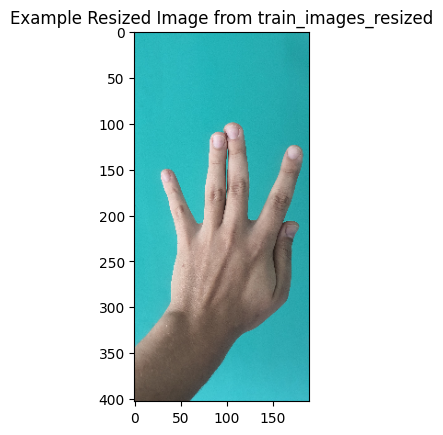

In [38]:
# Resize all images in train_images_rgb
train_images_resized = []
scale_dw = 10  # Define the scaling factor

for class_images in train_images_rgb:
    resized_class_images = []
    for image in class_images:
        w, h, _ = np.shape(image)
        # Ensure dimensions are positive integers before resizing
        new_w = max(1, int(w / scale_dw))
        new_h = max(1, int(h / scale_dw))
        img_resized = cv2.resize(image, (new_h, new_w))
        resized_class_images.append(img_resized)
    train_images_resized.append(resized_class_images)

# train_images_resized now contains all images resized by the scale_dw factor
# To display an example resized image:
plt.figure()
plt.imshow(train_images_resized[0][0])
plt.title("Example Resized Image from train_images_resized")
plt.show()

Extragerea mainii folosind culoarea pielii

Pentru o singura imagine

In [32]:
# prompt: write a function to segment skin color from images

def segment_skin(image):
    """Segments skin color from an image.

    Args:
        image: A NumPy array representing the input image in RGB format.

    Returns:
        A NumPy array representing the segmented skin region in binary format (0 or 255).
    """
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define the lower and upper bounds for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype="uint8")  # Adjust these values as needed
    upper_skin = np.array([20, 255, 255], dtype="uint8")

    # Create a mask for the skin color range
    mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    # Perform morphological operations to refine the mask (optional)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # Fill small holes

    return mask


Segmentare pentru tot setul

In [41]:
def segment_skin_list(images_list):
    """Segments skin color from a list of images.

    Args:
        images_list: A list of lists of NumPy arrays representing the input images in RGB format.

    Returns:
        A list of lists of NumPy arrays representing the segmented skin regions in binary format (0 or 255).
    """
    segmented_images_list = []
    for class_images in images_list:
        segmented_class_images = []
        for image in class_images:
            # Convert the image to the HSV color space
            hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

            # Define the lower and upper bounds for skin color in HSV
            lower_skin = np.array([0, 20, 70], dtype="uint8")  # Adjust these values as needed
            upper_skin = np.array([20, 255, 255], dtype="uint8")

            # Create a mask for the skin color range
            mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

            # Perform morphological operations to refine the mask (optional)
            kernel = np.ones((5, 5), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove small noise
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # Fill small holes

            segmented_class_images.append(mask)
        segmented_images_list.append(segmented_class_images)

    return segmented_images_list


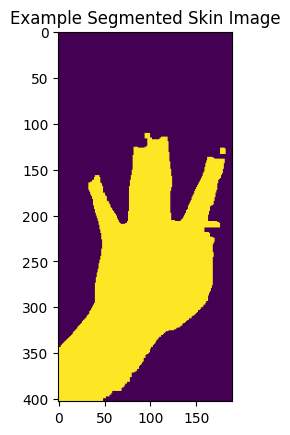

In [53]:
# Now you can use this function to segment all images in train_images_resized:
segmented_train_images = segment_skin_list(train_images_resized)
# You can display a segmented image like this:
plt.figure()
plt.imshow(segmented_train_images[0][0])
plt.title("Example Segmented Skin Image")
plt.show()

Pentru o singura imagine

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7c42db103050>)

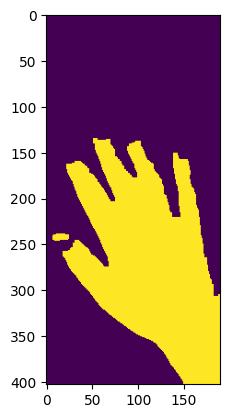

In [45]:
segmented_skin = segment_skin(img_resized)
plt.figure(), plt.imshow(segmented_skin)

Binarizare pentru tot setul

In [50]:
def binarizare_list(images_list):
    """Binarizes a list of images based on skin color criteria.

    Args:
        images_list: A list of lists of NumPy arrays representing the input images in RGB format.

    Returns:
        A list of lists of NumPy arrays representing the binarized skin regions (0 or 1).
    """
    binarized_images_list = []
    for class_images in images_list:
        binarized_class_images = []
        for img in class_images:
            R = img[:, :, 0]
            G = img[:, :, 1]
            B = img[:, :, 2]

            C1 = np.zeros((img.shape[0], img.shape[1]))
            C2 = np.zeros((img.shape[0], img.shape[1]))
            C3 = np.zeros((img.shape[0], img.shape[1]))
            C4 = np.zeros((img.shape[0], img.shape[1]))
            C5 = np.zeros((img.shape[0], img.shape[1]))
            C6 = np.zeros((img.shape[0], img.shape[1]))
            C7 = np.zeros((img.shape[0], img.shape[1]))
            rez = np.zeros((img.shape[0], img.shape[1]))

            C1[np.logical_and(R > 95, G > 40, B > 20)] = 1
            C2[(np.maximum(np.maximum(R, G), B) - np.minimum(np.minimum(R, G), B)) > 15] = 1
            C3[np.absolute(R - G) > 15] = 1
            C4[np.logical_and(R > G, R > B)] = 1

            C5[np.logical_and(R > 220, G > 210, B > 170)] = 1
            C6[np.absolute(R - G) <= 15] = 1
            C7[np.logical_and(R > B, G > B)] = 1


            caz1 = np.logical_and(np.logical_and(C1 == 1, C2 == 1, C3 == 1), C4 == 1)
            caz2 = np.logical_and(C5 == 1, C6 == 1, C7 == 1)

            rez[np.logical_or(caz1 == 1, caz2 == 1)] = 1

            binarized_class_images.append(rez)
        binarized_images_list.append(binarized_class_images)

    return binarized_images_list

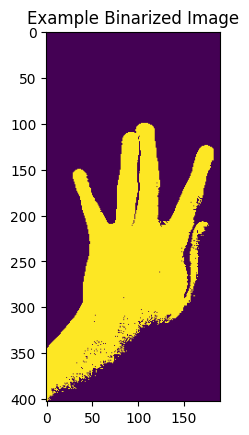

In [52]:
# Now you can use this function to binarize all images in train_images_resized:
binarized_train_images = binarizare_list(train_images_resized)

# You can display a binarized image like this:
plt.figure()
plt.imshow(binarized_train_images[0][0])
plt.title("Example Binarized Image")
plt.show()

Pentru o singura imagine

In [48]:
def binarizare(img):

    R = img[:, :, 0]
    G = img[: ,:, 1]
    B = img[:, :, 2]

    C1 = np.zeros((img.shape[0], img.shape[1]))
    C2 = np.zeros((img.shape[0], img.shape[1]))
    C3 = np.zeros((img.shape[0], img.shape[1]))
    C4 = np.zeros((img.shape[0], img.shape[1]))
    C5 = np.zeros((img.shape[0], img.shape[1]))
    C6 = np.zeros((img.shape[0], img.shape[1]))
    C7 = np.zeros((img.shape[0], img.shape[1]))
    rez = np.zeros((img.shape[0], img.shape[1]))

    C1[np.logical_and(R > 95, G > 40, B > 20)] = 1
    C2[(np.maximum(np.maximum(R, G), B) - np.minimum(np.minimum(R, G), B)) > 15] = 1
    C3[np.absolute(R - G) > 15] = 1
    C4[np.logical_and(R > G, R > B)] = 1

    C5[np.logical_and(R > 220, G > 210, B > 170)] = 1
    C6[np.absolute(R - G) <= 15] = 1
    C7[np.logical_and(R > B, G > B)] = 1


    caz1 = np.logical_and(np.logical_and(C1 == 1, C2 == 1, C3 == 1), C4 == 1)
    caz2 = np.logical_and(C5 ==1, C6 == 1, C7 == 1)

    rez[np.logical_or(caz1 == 1, caz2 == 1)] = 1

    return rez

Pentru o singura imagine

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7c42daffb510>)

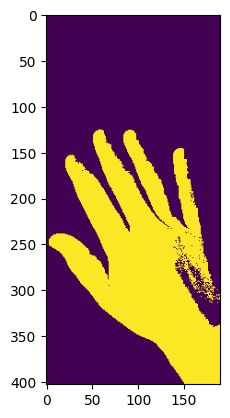

In [49]:
segmented_skin = binarizare(img_resized)
plt.figure(), plt.imshow(segmented_skin)

Pentru o singura imagine

In [54]:
contours, _ = cv2.findContours(segmented_skin.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7c42dada5210>)

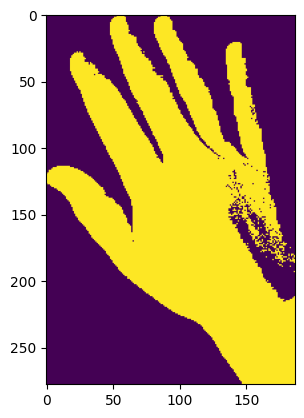

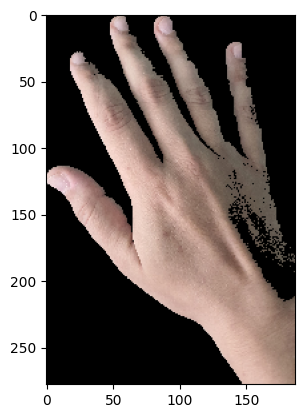

In [55]:
max_area = 0
max_bbox = None
for contour in contours:
  tmp = cv2.boundingRect(contour)
  arie = tmp[2]*tmp[3]
  if arie>max_area:
    max_area = arie
    max_bbox = tmp
segmented_skin = segmented_skin[max_bbox[1]:max_bbox[1]+max_bbox[3], max_bbox[0]:max_bbox[0]+max_bbox[2]]
img_resized = img_resized[max_bbox[1]:max_bbox[1]+max_bbox[3], max_bbox[0]:max_bbox[0]+max_bbox[2]]
img_resized[segmented_skin == 0] = 0
masked_image = img_resized
plt.figure(), plt.imshow(segmented_skin)
plt.figure(), plt.imshow(masked_image)


In [56]:
max_area

51986

In [57]:
max_bbox

(3, 125, 187, 278)

Contur pe intreg setul de date

In [60]:
# Find contours for all segmented images
all_contours = []
for class_segmented_images in segmented_train_images:
    class_contours = []
    for segmented_image in class_segmented_images:
        # Ensure the image is in uint8 format as required by findContours
        segmented_image_uint8 = segmented_image.astype(np.uint8)

        # Find contours
        contours, _ = cv2.findContours(segmented_image_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        class_contours.append(contours)
    all_contours.append(class_contours)

In [65]:
# Process all images to find the largest contour, crop, and mask
cropped_segmented_images = []
masked_original_images = []
image_stats = [] # New list to store stats (max_area and max_bbox) for each image

for class_index, class_contours in enumerate(all_contours):
    cropped_segmented_class = []
    masked_original_class = []
    class_stats = [] # New list for stats in this class

    for image_index, contours in enumerate(class_contours):
        max_area = 0
        max_bbox = None

        # Find the largest contour and its bounding box
        for contour in contours:
            tmp = cv2.boundingRect(contour)
            area = tmp[2] * tmp[3]
            if area > max_area:
                max_area = area
                max_bbox = tmp

        # Store the max area and max bbox for this image as a dictionary or tuple
        class_stats.append({'max_area': max_area, 'max_bbox': max_bbox}) # Storing as a dictionary

        # If a bounding box was found... (rest of the cropping and masking logic)
        if max_bbox is not None:
            x, y, w, h = max_bbox

            segmented_image = segmented_train_images[class_index][image_index]
            original_image = train_images_resized[class_index][image_index]

            cropped_segmented = segmented_image[y:y+h, x:x+w]
            cropped_original = original_image[y:y+h, x:x+w]

            cropped_segmented_mask = cropped_segmented.copy()
            cropped_segmented_mask[cropped_segmented_mask > 0] = 255

            masked_image = cv2.bitwise_and(cropped_original, cropped_original, mask=cropped_segmented_mask)

            cropped_segmented_class.append(cropped_segmented)
            masked_original_class.append(masked_image)
        else:
            cropped_segmented_class.append(None)
            masked_original_class.append(None)

    cropped_segmented_images.append(cropped_segmented_class)
    masked_original_images.append(masked_original_class)
    image_stats.append(class_stats) # Append the list of stats for this class

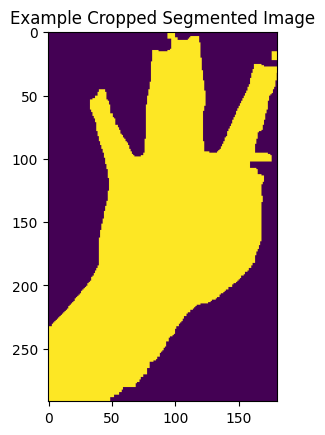

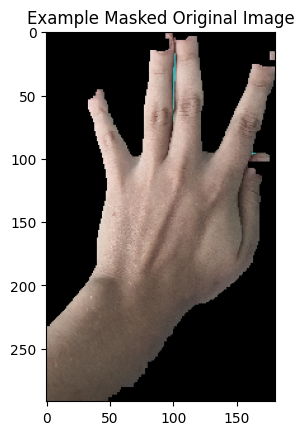

In [66]:
# To display an example cropped segmented image:
plt.figure()
plt.imshow(cropped_segmented_images[0][0])
plt.title("Example Cropped Segmented Image")
plt.show()

# To display an example masked original image:
plt.figure()
plt.imshow(masked_original_images[0][0])
plt.title("Example Masked Original Image")
plt.show()

In [67]:
# To see the stats for the first image of the first class:
print(image_stats[0][0])
# To access the max_area:
print(image_stats[0][0]['max_area'])
# To access the max_bbox:
print(image_stats[0][0]['max_bbox'])

{'max_area': 52852, 'max_bbox': (0, 111, 181, 292)}
52852
(0, 111, 181, 292)


In [58]:
#(170X270X3)
#(1Xnum_of_feat)

winSize = (32,32)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
randomValues = (32,32)
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
winStride = (8,8)
padding = (8,8)
locations = ((10,20),)
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)



In [59]:
# resize all images to same resolution

masked_image_rz = cv2.resize(masked_image, (64,128))
h = hog.compute(masked_image_rz,winStride,padding,locations)
print(h.shape)

(324,)


In [ ]:
# labels = []
# data = []
# l = 0
# [4,7,(img_size)]
# for class in mascked_image: 4
#   for img in class: 7
#     resize_image
#     hog(resized_image)
#     labels.append(l)
#     data.append(h[:,0])
#   l += 1

In [ ]:
knn = cv2.ml.KNearest_create()
knn.train(data, cv2.ml.ROW_SAMPLE, labels)

knn.findNearest(tst_data, 3)

In [ ]:
# SVM la fel!

In [ ]:
# MATRICI DE CONFUZIE

In [68]:
# Define your HOG descriptor parameters (already in your notebook)
winSize = (64, 128) # Common size for HOG, adjust if your cropped images have a different typical size
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
# You can adjust winStride and padding as needed
winStride = (8, 8)
padding = (0, 0) # Padding might not be necessary if images are already a suitable size

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                        histogramNormType, L2HysThreshold, gammaCorrection, nlevels)

# Extract HOG features from the masked and cropped images
features = []
labels = []

# Assuming your classes are represented by the index of the outer list in masked_original_images
for class_index, class_images in enumerate(masked_original_images):
    for image in class_images:
        # Ensure the image is not None (in case some images had no contours)
        if image is not None:
            # Resize the image to the HOG window size (winSize)
            # You might need to adjust this based on the typical size of your cropped hands
            resized_image = cv2.resize(image, winSize)

            # Compute the HOG features
            hog_features = hog.compute(resized_image)

            features.append(hog_features.flatten()) # Flatten the features into a 1D array
            labels.append(class_index) # Use the class index as the label

# Convert to NumPy arrays
features = np.array(features)
labels = np.array(labels)

print("Shape of features:", features.shape)
print("Shape of labels:", labels.shape)

Shape of features: (28, 3780)
Shape of labels: (28,)


In [69]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels) # Use stratify to maintain class distribution

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (22, 3780)
Shape of X_test: (6, 3780)
Shape of y_train: (22,)
Shape of y_test: (6,)


In [70]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train an SVM classifier
# You might need to tune the 'C' and 'kernel' parameters
svm_classifier = SVC(kernel='linear', C=1) # Linear kernel is a good starting point
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         1

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.58         6
weighted avg       0.75      0.67      0.67         6

Confusion Matrix:
[[1 0 0 1]
 [0 1 0 0]
 [0 0 2 0]
 [0 1 0 0]]


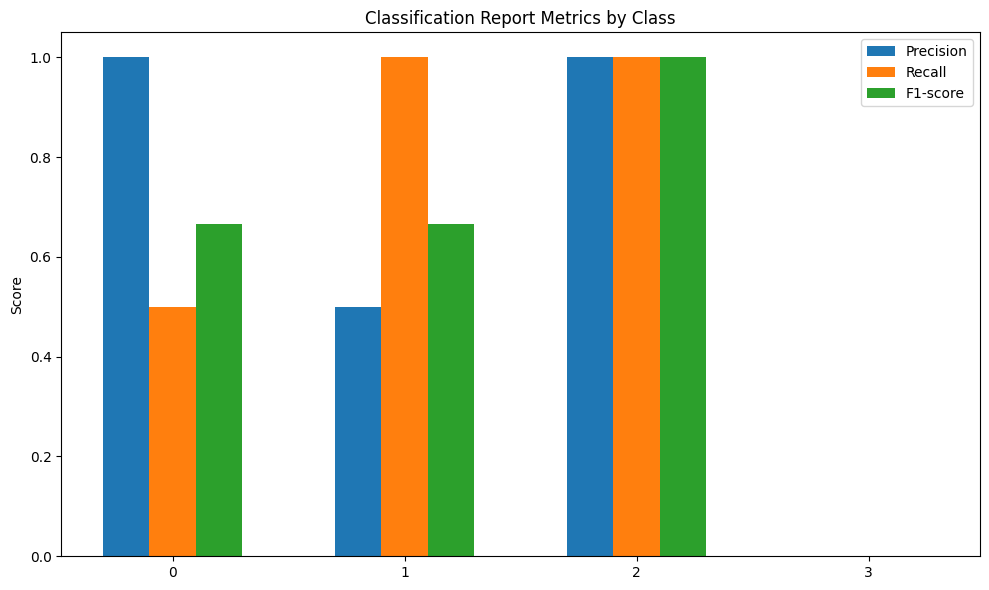

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have already run the SVM classification and have y_test and y_pred

# Get the classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Extract metrics for each class (excluding 'accuracy', 'macro avg', 'weighted avg')
classes = [str(i) for i in range(len(report) - 3)] # Assuming class labels are 0, 1, 2, 3...
precision = [report[c]['precision'] for c in classes]
recall = [report[c]['recall'] for c in classes]
f1_score = [report[c]['f1-score'] for c in classes]

x = np.arange(len(classes))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Classification Report Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# autolabel(rects1) # Uncomment if you want to display values on bars
# autolabel(rects2)
# autolabel(rects3)

fig.tight_layout()
plt.show()

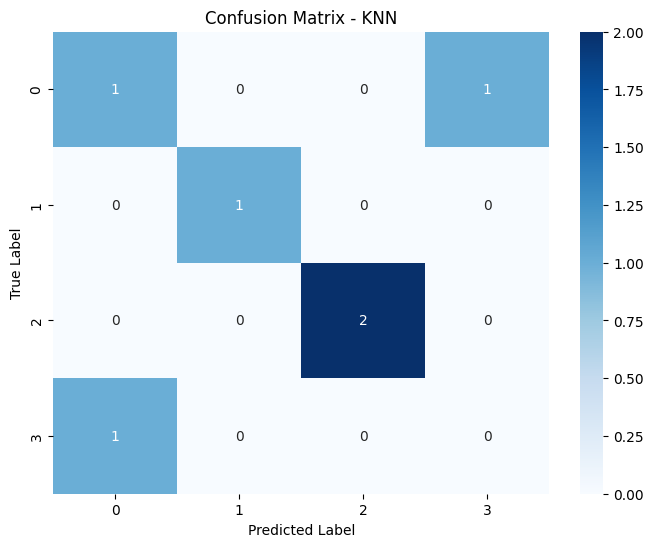

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already performed the train/test split:
# X_train, X_test, y_train, y_test

# Initialize and train a KNN classifier
# You can adjust the number of neighbors (n_neighbors)
knn_classifier = KNeighborsClassifier(n_neighbors=5) # 5 is a common starting point
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_knn = knn_classifier.predict(X_test)

# Compute the confusion matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Create a heatmap of the confusion matrix for KNN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(cm_knn.shape[1])],
            yticklabels=[str(i) for i in range(cm_knn.shape[0])])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN')
plt.show()

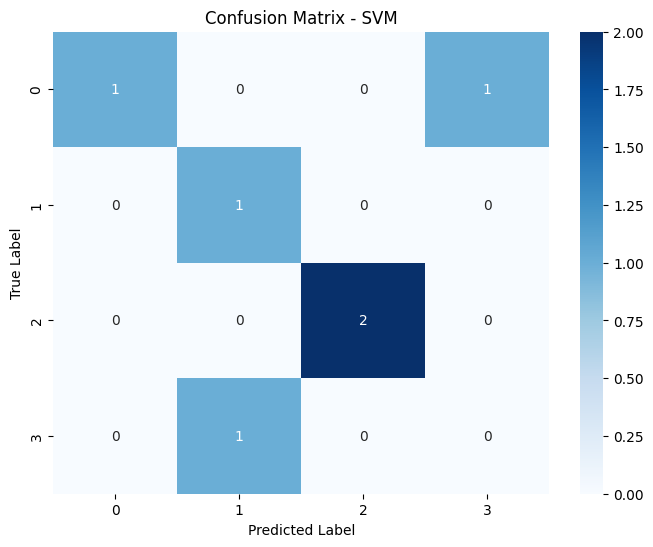

In [74]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already performed the train/test split:
# X_train, X_test, y_train, y_test

# Initialize and train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Compute the confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Create a heatmap of the confusion matrix for SVM
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(cm_svm.shape[1])],
            yticklabels=[str(i) for i in range(cm_svm.shape[0])])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM')
plt.show()

In [75]:
# --- Preprocessing for train_images ---

# Convert to RGB
train_images_rgb = []
for class_images in train_images:
    rgb_class_images = []
    for image in class_images:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        rgb_class_images.append(rgb_image)
    train_images_rgb.append(rgb_class_images)

# Resize images
train_images_resized = []
scale_dw = 10
for class_images in train_images_rgb:
    resized_class_images = []
    for image in class_images:
        w, h, _ = np.shape(image)
        new_w = max(1, int(w / scale_dw))
        new_h = max(1, int(h / scale_dw))
        img_resized = cv2.resize(image, (new_h, new_w))
        resized_class_images.append(img_resized)
    train_images_resized.append(resized_class_images)

# Segment skin
segmented_train_images = segment_skin_list(train_images_resized)

# Find contours and mask (applying the contour and masking logic from before)
all_contours_train = []
for class_segmented_images in segmented_train_images:
    class_contours = []
    for segmented_image in class_segmented_images:
        segmented_image_uint8 = segmented_image.astype(np.uint8)
        contours, _ = cv2.findContours(segmented_image_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        class_contours.append(contours)
    all_contours_train.append(class_contours)

masked_original_images_train = []
for class_index, class_contours in enumerate(all_contours_train):
    masked_original_class = []
    for image_index, contours in enumerate(class_contours):
        max_area = 0
        max_bbox = None
        for contour in contours:
            tmp = cv2.boundingRect(contour)
            area = tmp[2] * tmp[3]
            if area > max_area:
                max_area = area
                max_bbox = tmp

        if max_bbox is not None:
            x, y, w, h = max_bbox
            original_image = train_images_resized[class_index][image_index]
            cropped_original = original_image[y:y+h, x:x+w]
            segmented_image = segmented_train_images[class_index][image_index]
            cropped_segmented = segmented_image[y:y+h, x:x+w]
            cropped_segmented_mask = cropped_segmented.copy()
            cropped_segmented_mask[cropped_segmented_mask > 0] = 255
            masked_image = cv2.bitwise_and(cropped_original, cropped_original, mask=cropped_segmented_mask)
            masked_original_class.append(masked_image)
        else:
            masked_original_class.append(None)
    masked_original_images_train.append(masked_original_class)


# --- Preprocessing for test_images ---

# Convert to RGB
test_images_rgb = []
for class_images in test_images:
    rgb_class_images = []
    for image in class_images:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        rgb_class_images.append(rgb_image)
    test_images_rgb.append(rgb_class_images)

# Resize images
test_images_resized = []
for class_images in test_images_rgb:
    resized_class_images = []
    for image in class_images:
        w, h, _ = np.shape(image)
        new_w = max(1, int(w / scale_dw))
        new_h = max(1, int(h / scale_dw))
        img_resized = cv2.resize(image, (new_h, new_w))
        resized_class_images.append(img_resized)
    test_images_resized.append(resized_class_images)

# Segment skin
segmented_test_images = segment_skin_list(test_images_resized)

# Find contours and mask (applying the contour and masking logic from before)
all_contours_test = []
for class_segmented_images in segmented_test_images:
    class_contours = []
    for segmented_image in class_segmented_images:
        segmented_image_uint8 = segmented_image.astype(np.uint8)
        contours, _ = cv2.findContours(segmented_image_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        class_contours.append(contours)
    all_contours_test.append(class_contours)

masked_original_images_test = []
for class_index, class_contours in enumerate(all_contours_test):
    masked_original_class = []
    for image_index, contours in enumerate(class_contours):
        max_area = 0
        max_bbox = None
        for contour in contours:
            tmp = cv2.boundingRect(contour)
            area = tmp[2] * tmp[3]
            if area > max_area:
                max_area = area
                max_bbox = tmp

        if max_bbox is not None:
            x, y, w, h = max_bbox
            original_image = test_images_resized[class_index][image_index]
            cropped_original = original_image[y:y+h, x:x+w]
            segmented_image = segmented_test_images[class_index][image_index]
            cropped_segmented = segmented_image[y:y+h, x:x+w]
            cropped_segmented_mask = cropped_segmented.copy()
            cropped_segmented_mask[cropped_segmented_mask > 0] = 255
            masked_image = cv2.bitwise_and(cropped_original, cropped_original, mask=cropped_segmented_mask)
            masked_original_class.append(masked_image)
        else:
            masked_original_class.append(None)
    masked_original_images_test.append(masked_original_class)

In [76]:
# Define your HOG descriptor parameters (same as before)
winSize = (64, 128)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
winStride = (8, 8)
padding = (0, 0)

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                        histogramNormType, L2HysThreshold, gammaCorrection, nlevels)

# Extract HOG features from processed train images
X_train = []
y_train = []
for class_index, class_images in enumerate(masked_original_images_train):
    for image in class_images:
        if image is not None:
            resized_image = cv2.resize(image, winSize)
            hog_features = hog.compute(resized_image)
            X_train.append(hog_features.flatten())
            y_train.append(class_index)

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Extract HOG features from processed test images
X_test = []
y_test = []
for class_index, class_images in enumerate(masked_original_images_test):
    for image in class_images:
        if image is not None:
            resized_image = cv2.resize(image, winSize)
            hog_features = hog.compute(resized_image)
            X_test.append(hog_features.flatten())
            y_test.append(class_index)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (28, 3780)
Shape of y_train: (28,)
Shape of X_test: (12, 3780)
Shape of y_test: (12,)


--- KNN Classification Report ---
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.00      0.00      0.00         3
           2       1.00      1.00      1.00         3
           3       0.67      0.67      0.67         3

    accuracy                           0.58        12
   macro avg       0.54      0.58      0.56        12
weighted avg       0.54      0.58      0.56        12



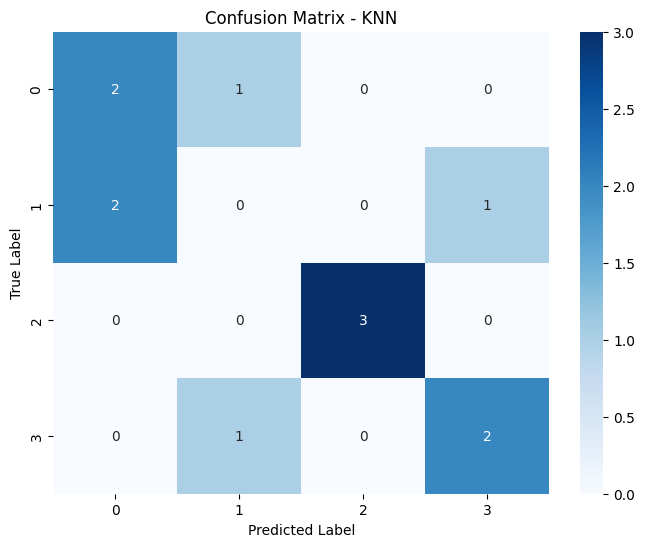

--- SVM Classification Report ---
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.00      0.00      0.00         3
           2       1.00      1.00      1.00         3
           3       0.67      0.67      0.67         3

    accuracy                           0.58        12
   macro avg       0.54      0.58      0.56        12
weighted avg       0.54      0.58      0.56        12



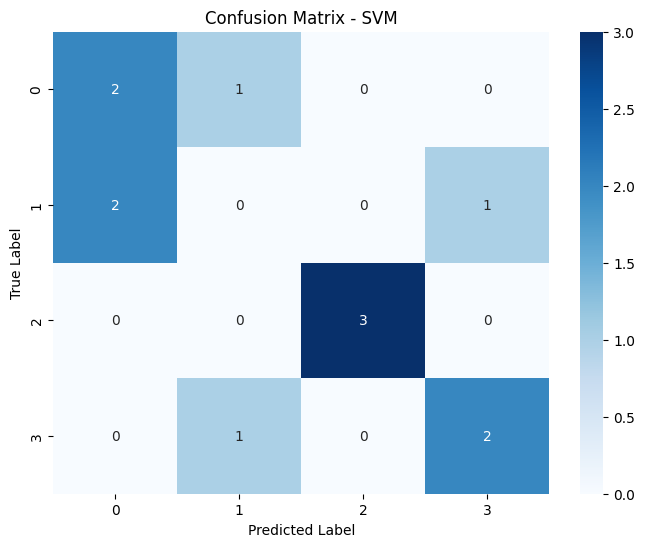

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Train and Evaluate KNN ---
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

print("--- KNN Classification Report ---")
print(classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(cm_knn.shape[1])],
            yticklabels=[str(i) for i in range(cm_knn.shape[0])])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN')
plt.show()

# --- Train and Evaluate SVM ---
svm_classifier = SVC(kernel='poly', C=1)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

print("--- SVM Classification Report ---")
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(cm_svm.shape[1])],
            yticklabels=[str(i) for i in range(cm_svm.shape[0])])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 40 images.
Loaded 40 labels.
Number of training images: 32
Number of testing images: 8
Number of training labels: 32
Number of testing labels: 8
Processed 32 training images.
Processed 8 testing images.
Filtered training images: 32
Filtered testing images: 8
Shape of X_train_features: (32, 3780)
Shape of X_test_features: (8, 3780)
--- KNN Classification Report ---
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2

    accuracy                           0.75         8
   macro avg       0.88      0.75      0.75         8
weighted avg       0.88      0.75      0.75         8



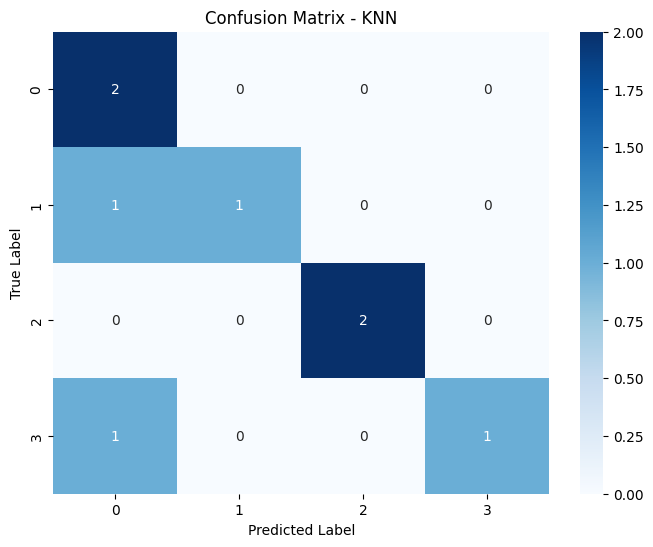

--- SVM Classification Report ---
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.50      0.50      0.50         2
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2

    accuracy                           0.75         8
   macro avg       0.79      0.75      0.74         8
weighted avg       0.79      0.75      0.74         8



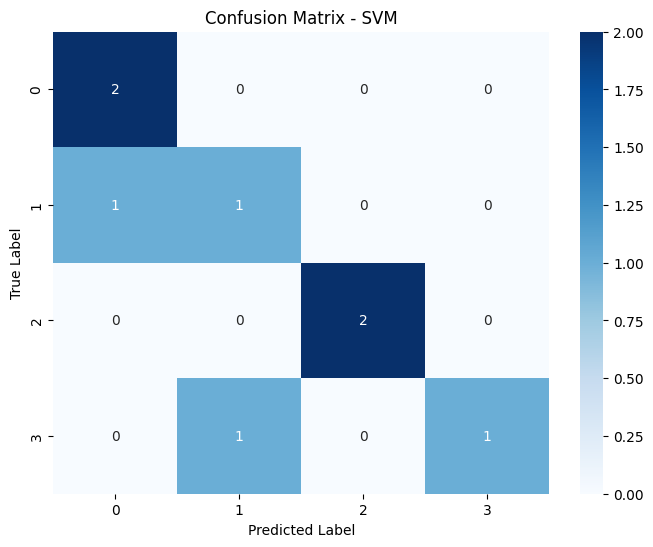

In [90]:
# %% [markdown]
# 0. Import Libs
# %%
import cv2
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# %% [markdown]
# 1. Mount Google Drive and Import Data
# %%
from google.colab import drive
drive.mount('/content/drive')

# Define the base path to your image data
bp = "/content/drive/MyDrive/fac/Laborator/Images/"
file_path_arr = []
for i in range(4):
  file_path_arr.append(glob.glob(bp+str(i)+'/*.jpg'))

# Load images
all_images = []
all_labels = []

for class_index, class_paths in enumerate(file_path_arr):
  for img_path in class_paths:
    img = cv2.imread(img_path)
    if img is not None: # Check if image loading was successful
      all_images.append(img)
      all_labels.append(class_index)

print(f"Loaded {len(all_images)} images.")
print(f"Loaded {len(all_labels)} labels.")

# %% [markdown]
# 2. Shuffle Data
# %%
# Combine images and labels
combined_data = list(zip(all_images, all_labels))

# Shuffle the combined data
random.seed(42) # Use the same seed for reproducibility
random.shuffle(combined_data)

# Separate images and labels again
shuffled_images, shuffled_labels = zip(*combined_data)
shuffled_images = list(shuffled_images)
shuffled_labels = list(shuffled_labels)

# %% [markdown]
# 3. Train-Test Split
# %%
# Split the shuffled data into training and testing sets
# Using stratify to ensure similar class distribution in both sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    shuffled_images, shuffled_labels, test_size=0.2, random_state=42, stratify=shuffled_labels
)

print(f"Number of training images: {len(X_train_raw)}")
print(f"Number of testing images: {len(X_test_raw)}")
print(f"Number of training labels: {len(y_train)}")
print(f"Number of testing labels: {len(y_test)}")

# %% [markdown]
# 4. Preprocess Data (Resize, Skin Segmentation, Masking)
# %%
# Functions for skin segmentation and binarization from your notebook
def segment_skin(image):
    """Segments skin color from an image (single image)."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_skin = np.array([0, 20, 70], dtype="uint8")
    upper_skin = np.array([20, 255, 255], dtype="uint8")
    mask = cv2.inRange(hsv_image, lower_skin, upper_skin)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def binarizare(img):
    """Binarizes an image based on skin color criteria (single image)."""
    R = img[:, :, 0]
    G = img[: ,:, 1]
    B = img[:, :, 2]
    C1 = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    C2 = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    C3 = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    C4 = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    C5 = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    C6 = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    C7 = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    rez = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    C1[np.logical_and(R > 95, G > 40, B > 20)] = 1
    C2[(np.maximum(np.maximum(R, G), B) - np.minimum(np.minimum(R, G), B)) > 15] = 1
    C3[np.absolute(R - G) > 15] = 1
    C4[np.logical_and(R > G, R > B)] = 1
    C5[np.logical_and(R > 220, G > 210, B > 170)] = 1
    C6[np.absolute(R - G) <= 15] = 1
    C7[np.logical_and(R > B, G > B)] = 1

    caz1 = np.logical_and(np.logical_and(C1 == 1, C2 == 1, C3 == 1), C4 == 1)
    caz2 = np.logical_and(C5 ==1, C6 == 1, C7 == 1)

    rez[np.logical_or(caz1 == 1, caz2 == 1)] = 1
    return rez * 255 # Return binary mask (0 or 255)

def process_images(image_list, scale_dw=10):
    processed_images = []
    for image in image_list:
        # Convert to RGB
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize
        w, h, _ = np.shape(rgb_image)
        new_w = max(1, int(w / scale_dw))
        new_h = max(1, int(h / scale_dw))
        img_resized = cv2.resize(rgb_image, (new_h, new_w))

        # Segment skin (using the binarization method from your notebook)
        segmented_skin_mask = binarizare(img_resized)

        # Find the largest contour (assuming it's the hand)
        contours, _ = cv2.findContours(segmented_skin_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_area = 0
        max_bbox = None
        for contour in contours:
            tmp = cv2.boundingRect(contour)
            area = tmp[2] * tmp[3]
            if area > max_area:
                max_area = area
                max_bbox = tmp

        masked_image = None
        if max_bbox is not None:
            x, y, w, h = max_bbox
            # Crop the original resized image and the segmented mask
            cropped_original = img_resized[y:y+h, x:x+w]
            cropped_segmented_mask = segmented_skin_mask[y:y+h, x:x+w]

            # Apply the mask to the cropped original image
            # Ensure mask is 3 channels for bitwise_and with a color image
            cropped_segmented_mask_3channel = cv2.cvtColor(cropped_segmented_mask, cv2.COLOR_GRAY2BGR)
            masked_image = cv2.bitwise_and(cropped_original, cropped_segmented_mask_3channel)

        processed_images.append(masked_image) # Append None if no valid contour was found

    return processed_images

# Process training and testing images
X_train_processed = process_images(X_train_raw)
X_test_processed = process_images(X_test_raw)

print(f"Processed {len(X_train_processed)} training images.")
print(f"Processed {len(X_test_processed)} testing images.")

# Filter out images where processing failed (masked_image is None)
# Also filter the corresponding labels
X_train_filtered = [img for img in X_train_processed if img is not None]
y_train_filtered = [y_train[i] for i, img in enumerate(X_train_processed) if img is not None]

X_test_filtered = [img for img in X_test_processed if img is not None]
y_test_filtered = [y_test[i] for i, img in enumerate(X_test_processed) if img is not None]

print(f"Filtered training images: {len(X_train_filtered)}")
print(f"Filtered testing images: {len(X_test_filtered)}")

y_train_filtered = np.array(y_train_filtered)
y_test_filtered = np.array(y_test_filtered)

# %% [markdown]
# 5. Feature Extraction (HOG)
# %%
# Define HOG descriptor parameters
winSize = (64, 128)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 0
nlevels = 64
winStride = (8, 8)
padding = (0, 0)

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                        histogramNormType, L2HysThreshold, gammaCorrection, nlevels)

# Extract HOG features
X_train_features = []
for img in X_train_filtered:
    # Resize to HOG window size before computing features
    resized_img = cv2.resize(img, winSize)
    hog_features = hog.compute(resized_img)
    X_train_features.append(hog_features.flatten())

X_test_features = []
for img in X_test_filtered:
    # Resize to HOG window size before computing features
    resized_img = cv2.resize(img, winSize)
    hog_features = hog.compute(resized_img)
    X_test_features.append(hog_features.flatten())

X_train_features = np.array(X_train_features)
X_test_features = np.array(X_test_features)

print("Shape of X_train_features:", X_train_features.shape)
print("Shape of X_test_features:", X_test_features.shape)

# %% [markdown]
# 6. Classification (KNN and SVM)
# %%
# --- Train and Evaluate KNN ---
knn_classifier = KNeighborsClassifier(n_neighbors=5) # You can tune n_neighbors
knn_classifier.fit(X_train_features, y_train_filtered)
y_pred_knn = knn_classifier.predict(X_test_features)

print("--- KNN Classification Report ---")
print(classification_report(y_test_filtered, y_pred_knn))

cm_knn = confusion_matrix(y_test_filtered, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(cm_knn.shape[1])],
            yticklabels=[str(i) for i in range(cm_knn.shape[0])])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN')
plt.show()

# --- Train and Evaluate SVM ---
svm_classifier = SVC(kernel='rbf', C=1) # You can tune kernel and C
svm_classifier.fit(X_train_features, y_train_filtered)
y_pred_svm = svm_classifier.predict(X_test_features)

print("--- SVM Classification Report ---")
print(classification_report(y_test_filtered, y_pred_svm))

cm_svm = confusion_matrix(y_test_filtered, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(cm_svm.shape[1])],
            yticklabels=[str(i) for i in range(cm_svm.shape[0])])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM')
plt.show()